# Boulder Opal optimized gate for different sets of parameters

This notebook executes the Boulder Opal optimization with the physical setting and constraints of the Saffman et al. paper. The code is essentially taken from the Boulder Opal website:

https://docs.q-ctrl.com/boulder-opal/apply/rydberg-atom-quantum-computing/design-robust-rydberg-blockade-two-qubit-gates-in-cold-atoms

First the optimization function is defined, then the optimization is done for different maximum pulse amplitudes and protocol times. The final fidelities are stored in a .txt file and can then be plotted in another notebook.

## Preliminaries

In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import qctrlvisualizer as qv
import boulderopal as bo

bo.cloud.set_verbosity("QUIET")
plt.style.use(qv.get_qctrl_style())

controls_for_plots = lambda opt: {
    "$\\Omega$": opt["output"]["amplitude"],
    "$\\Delta$": opt["output"]["detuning"],
}

Boulder Opal client update available.
Latest version is 3.0.0, you have 2.1.3.
Visit https://docs.q-ctrl.com/boulder-opal/changelog for the latest product updates.


In [2]:
# Set segment count.
segment_count = 256

# Define system operators.
basis_labels = ["00", "01", "10", "11", "0r", "r0", "1r", "r1", "rr"]
drive_operator = np.zeros((9, 9))
drive_operator[([1, 2, 3, 3, 6, 7], [4, 5, 6, 7, 8, 8])] = 1
detuning_operator = np.diag([0, 0, 0, 0, 1, 1, 1, 1, 2])
blockade_operator = np.zeros((9, 9))
blockade_operator[8, 8] = 1

# Components for the CZ operator.
h_00 = np.zeros((9, 9))
h_00[0, 0] = 1
h_01 = np.zeros((9, 9))
h_01[1, 1] = 1
h_01[2, 2] = 1
h_11 = np.zeros((9, 9))
h_11[3, 3] = 1

### Optimizing the CZ gate

In [3]:
# Graph for blockade strengths B in rad/s.
def optimize_cz_gate(
    pulse_scheme, blockade_strength, duration, Omega_0, Delta_0, cost_node, optimization_count=10, **robustness
):
    graph = bo.Graph()
    tau = 0.175 * duration
    t0 = duration / 4
    a = np.exp(-((t0 / tau) ** 4))
    sample_times = np.linspace(0, duration, segment_count)
    cutoff_frequency = Omega_0

    if pulse_scheme == "ARP":
        # Create the discretized ARP envelope.
        times = np.linspace(0, duration / 2, segment_count)
        amplitude = (
            Omega_0
            * (np.exp(-(((times - t0) / tau) ** 4)) - np.exp(-((t0 / tau) ** 4)))
            / (1 - a)
        )
        detuning = Delta_0 * np.sin(2 * np.pi * (times - t0) / duration)

        Omega = graph.pwc_signal(values=amplitude, duration=duration / 2)
        Delta = graph.pwc_signal(values=detuning, duration=duration / 2)

        # 2 pulses to implement the gate.
        Omega = graph.time_concatenate_pwc([Omega, Omega], name="amplitude")
        Delta = graph.time_concatenate_pwc([Delta, Delta], name="detuning")

    else:
        opt_var_count = 20
        flat_gaussian_envelope = graph.signals.gaussian_pulse_pwc(
            duration=duration,
            segment_count=segment_count,
            amplitude=1,
            flat_duration=duration * 0.9,  # s
        )
        amplitude = graph.real_optimizable_pwc_signal(
            segment_count=opt_var_count, maximum=Omega_0, duration=duration
        )
        detuning = graph.real_optimizable_pwc_signal(
            segment_count=opt_var_count,
            maximum=Delta_0,
            minimum=-Delta_0,
            duration=duration,
        )
        Omega = graph.filter_and_resample_pwc(
            amplitude,
            kernel=graph.sinc_convolution_kernel(cutoff_frequency),
            segment_count=segment_count,
        )
        Omega = Omega * flat_gaussian_envelope
        Omega.name = "amplitude"
        Delta = graph.filter_and_resample_pwc(
            detuning,
            kernel=graph.sinc_convolution_kernel(cutoff_frequency),
            segment_count=segment_count,
        )
        Delta = Delta * flat_gaussian_envelope
        Delta.name = "detuning"

    # Create Hamiltonian.
    drive_term = graph.hermitian_part(Omega * drive_operator)
    delta_term = Delta * detuning_operator
    blockade_term = blockade_strength * blockade_operator
    hamiltonian = drive_term + delta_term + blockade_term

    # Single-qubit rotation is a free parameter, can be optimized for best fidelity.
    theta_s = graph.optimizable_scalar(
        lower_bound=0.0,
        upper_bound=2 * np.pi,
        is_lower_unbounded=True,
        is_upper_unbounded=True,
        name="theta_s",
    )

    # Define target operation.
    cz_op = (
        h_00
        + graph.exp(1j * theta_s) * h_01
        + graph.exp(1j * (2 * theta_s + np.pi)) * h_11
    )
    target = graph.target(operator=cz_op)

    # Define noise list to include robustness.
    noise_list = []
    if robustness["dephasing"]:
        noise_list.append(detuning_operator / duration)
    if robustness["amplitude"]:
        noise_list.append(drive_term)
    penalty = robustness["decay"]

    infidelity = graph.infidelity_pwc(
        hamiltonian=hamiltonian,
        target=target,
        noise_operators=noise_list,
        name="infidelity",
    )

    unitary = graph.time_evolution_operators_pwc(
        hamiltonian=hamiltonian, sample_times=sample_times, name="unitary"
    )

    # Node to store blockade value used (in Hz).
    blockade = graph.abs(blockade_strength / 2 / np.pi)
    blockade.name = "blockade"

    # Node to store duration value used (in Hz).
    duration = graph.abs(duration)
    duration.name = "duration"

    decay_cost = graph.sum(
        graph.abs(unitary[:, 4, 1]) ** 2
        + graph.abs(unitary[:, 5, 2]) ** 2
        + graph.abs(unitary[:, 6, 3]) ** 2
        + graph.abs(unitary[:, 7, 3]) ** 2
        + 2 * graph.abs(unitary[:, 8, 3]) ** 2
    ) * (0.25 * sample_times[1] / sample_times[-1])

    decay_cost.name = "decay cost"

    cost = graph.log(infidelity + penalty * decay_cost, name="cost")

    result = bo.run_optimization(
        graph=graph,
        output_node_names=[
            "theta_s",
            "amplitude",
            "detuning",
            "unitary",
            "infidelity",
            "blockade",
            "duration",
            "decay cost",
        ],
        cost_node_name=cost_node,
        optimization_count=optimization_count,
    )

    return result

Gate infidelity is 6.068e-10
Single-qubit phase is -2.563


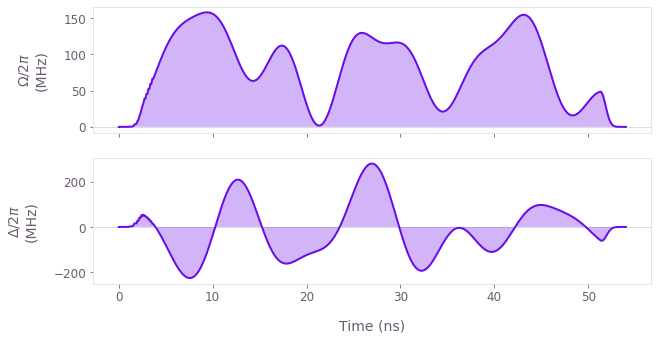

In [4]:
# Run the optimization for a set of test parameters
opt_result = optimize_cz_gate(
    pulse_scheme="opt",
    blockade_strength=2.5e9 * 2 * np.pi,
    duration = 1e-9 * 54,
    Omega_0 = 170 * 2 * np.pi * 1e6,  # rad/s
    Delta_0 = 230 * 2 * np.pi * 1e6,  # rad/s
    cost_node="infidelity",
    dephasing=False,
    amplitude=False,
    decay=0.0,
)

print("Gate infidelity is", f"{opt_result['output']['infidelity']['value']:.3e}")
print("Single-qubit phase is", f"{opt_result['output']['theta_s']['value']:.3f}")

qv.plot_controls(controls_for_plots(opt_result), smooth=True)

## Running the optimization

The number of parameters is reduced here to 4x4. For higher resolution plots it is reccomended to make multiple runs, store each .txt file individually and concatenate them later, since otherwise one may encounter runtime errors. 

In [5]:
# Vary duration from 54µs to 540µs
N            = 4
durations    = 1e-9 * 540 * np.logspace(-1.3010, 0, 1 * N)
scales       = np.logspace(0, 1, 4)
Omega_0s     = scales * 17 * 2 * np.pi * 1e6  # rad/s
Delta_0s     = scales * 23 * 2 * np.pi * 1e6  # rad/s
infidelities = np.zeros([len(scales), len(durations)])

# Optimize for each set of parameters
for i, (Omega_0, Delta_0) in enumerate(zip(Omega_0s, Delta_0s)):
    for j in range(N):
        duration_scan_results = {}

        with bo.cloud.group_requests():
            duration_scan_results[f'Optimal, non-robust {j}'] = [
                optimize_cz_gate(
                    "optimal",
                    blockade_strength=0.5e9 * 2 * np.pi,
                    duration=D,
                    Omega_0 = Omega_0,
                    Delta_0 = Delta_0,
                    cost_node="infidelity",
                    dephasing=False,
                    amplitude=False,
                    decay=0.0,
                )
                for D in durations[j*5:j*5+5]
            ]
        print(f'finished s={np.round(scales[i], 2)}, T={np.round(durations[j], 3)}')

        infidelities[i][j*5:j*5+5] = (np.array((
        [opt["output"]["infidelity"]["value"] 
        for opt in duration_scan_results[f'Optimal, non-robust {j}']]  
        ))
        ).flatten()

print('finished all')

# Save ndarray of fidelities
np.savetxt('../data/infids_acc_boo.txt', infidelities)

finished s=1.0, T=0.0
finished s=1.0, T=0.0
finished s=1.0, T=0.0
finished s=1.0, T=0.0
finished s=2.15, T=0.0
finished s=2.15, T=0.0
finished s=2.15, T=0.0
finished s=2.15, T=0.0
finished s=4.64, T=0.0
finished s=4.64, T=0.0
finished s=4.64, T=0.0
finished s=4.64, T=0.0
finished s=10.0, T=0.0
finished s=10.0, T=0.0
finished s=10.0, T=0.0
finished s=10.0, T=0.0
finished all


## Plot output

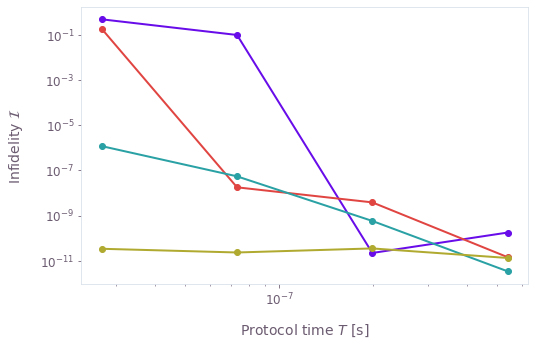

In [6]:
# Plot the fidelities
fig, ax = plt.subplots(1, 1, figsize = (8, 5))

for i in range(len(scales)):
    color = plt.get_cmap('plasma')(i / len(scales))
    ax.plot(durations, infidelities[i], marker='o')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Protocol time $T$ [s]')
ax.set_ylabel('Infidelity $\mathcal{I}$')
plt.show()